[과제]

diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
.zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('dataset/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head()


0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
# 평가 지표 함수
from sklearn.metrics import accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

def get_clf_eval(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬:\n',confusion)
    print('정확도:{:.4f}, 정밀도:{:.4f}, 재현율:{:.4f}, f1:{:.4f}, \
    auc:{:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [3]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

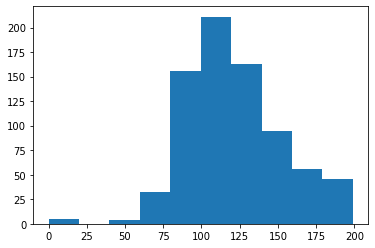

In [4]:
# Glucose 피처는 포도당 수치인데 min 값이 0인 것은 문제가 있음
plt.hist(diabetes_data.Glucose, bins=10)

In [25]:
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

total_count = diabetes_data.Glucose.count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0인 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature,
                                               zero_count,
                                               100*zero_count/total_count))
    

Glucose 0인 건수는 5, 퍼센트는 0.65 %
BloodPressure 0인 건수는 35, 퍼센트는 4.56 %
SkinThickness 0인 건수는 227, 퍼센트는 29.56 %
Insulin 0인 건수는 374, 퍼센트는 48.70 %
BMI 0인 건수는 11, 퍼센트는 1.43 %


In [26]:
diabetes_data[zero_features]= \
diabetes_data[zero_features].replace(0,diabetes_data[zero_features].mean())

In [27]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,
                                              test_size=0.2,
                                              random_state=156,
                                              stratify=y)
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test , pred, pred_proba)

오차 행렬:
 [[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, f1:0.6804,     auc:0.8433


In [30]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 
    # 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()

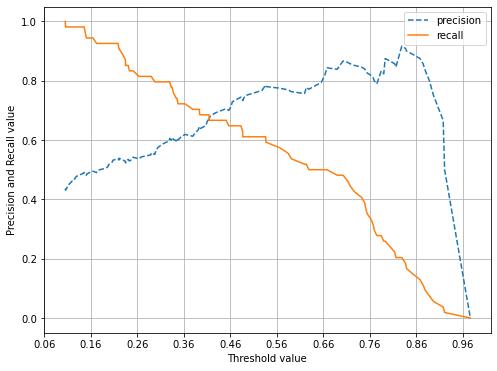

In [31]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test,pred_proba_c1)

In [28]:
from sklearn.preprocessing import Binarizer
def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:',custom_threshold)
        get_clf_eval(y_test,custom_predict,pred_proba_c1)

In [29]:
thresholds = [0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임계값: 0.3
오차 행렬:
 [[67 33]
 [11 43]]
정확도:0.7143, 정밀도:0.5658, 재현율:0.7963, f1:0.6615,     auc:0.8433
임계값: 0.33
오차 행렬:
 [[72 28]
 [12 42]]
정확도:0.7403, 정밀도:0.6000, 재현율:0.7778, f1:0.6774,     auc:0.8433
임계값: 0.36
오차 행렬:
 [[76 24]
 [15 39]]
정확도:0.7468, 정밀도:0.6190, 재현율:0.7222, f1:0.6667,     auc:0.8433
임계값: 0.39
오차 행렬:
 [[78 22]
 [16 38]]
정확도:0.7532, 정밀도:0.6333, 재현율:0.7037, f1:0.6667,     auc:0.8433
임계값: 0.42
오차 행렬:
 [[84 16]
 [18 36]]
정확도:0.7792, 정밀도:0.6923, 재현율:0.6667, f1:0.6792,     auc:0.8433
임계값: 0.45
오차 행렬:
 [[85 15]
 [18 36]]
정확도:0.7857, 정밀도:0.7059, 재현율:0.6667, f1:0.6857,     auc:0.8433
임계값: 0.48
오차 행렬:
 [[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, f1:0.6931,     auc:0.8433
임계값: 0.5
오차 행렬:
 [[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, f1:0.6804,     auc:0.8433


In [21]:
binarizer1 = Binarizer(threshold=0.48)
pred_th_048 = binarizer1.fit_transform(pred_proba[:,1].reshape(-1,1))
print(get_clf_eval(y_test,pred_th_048,pred_proba[:,1]))

오차 행렬:
 [[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, f1:0.6931,     auc:0.8433
None
